In [1]:
using Statistics

using ProgressMeter

using DifferentialEquations
using Printf
using Plots
gr(fmt="png", size=(800, 300))

include("../src/HHModel.jl")

Main.HHModel

# Persistent Sodium Plus Potassium Model

$$C\dot{V} = I - g_{\text{L}}(V - E_{\text{L}}) - g_{\text{Na}}m_\infty(V)(V-E_{\text{Na}}) - g_{\text{K}}n(V - E_{\text{K}})$$

$$\dot{n} = \frac{n_\infty(V) - n}{\tau_n(V)}$$

for purpose of even more simplification, let $\tau_n = 1$.

In [8]:
# Biophysics setup

Na_m = HHModel.Kinetics(1, -20.0, 15.0, _type=:instantaneous)
Na = HHModel.SimpleIonChannel("Persistent Sodium", :sodium, 20.0,
    Na_m, HHModel.Kinetics());

K_m = HHModel.Kinetics(1, -25.0, 5.0)
K = HHModel.SimpleIonChannel("Persistent Potassium", :potassium, 15.0,
    K_m, HHModel.Kinetics());

L = HHModel.SimpleIonChannel("Leakage", :leak, 8.0,
    HHModel.Kinetics(), HHModel.Kinetics()
);

In [9]:
# stimulus setup
function stimulus(t, param)
    (param.start < t)&(t < param.dur + param.start) ? param.current : 0
end

stimulus (generic function with 1 method)

In [32]:
# create model cell
_model = HHModel.simpleConductanceModel([Na, K, L], stimulus)

#45 (generic function with 1 method)

In [35]:
_model(zeros(3), [-66.0, 0.0, 0.0], _p, 10)[1]

3-element Array{Float64,1}:
 0.14845526096334538
 0.0                
 0.0                

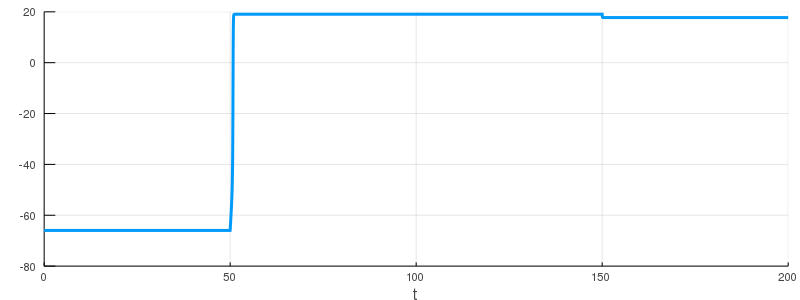

In [29]:
# setup initial values and run the simulation
u0 = HHModel.setup_init([Na, K, L], -66)
tspan = (0.0, 200.0)

# K.m.Vhalf = -30.5
# HHModel.update!(K) 
# _model = HHModel.simpleConductanceModel([Na, K, L], stimulus)

_p = (E=(sodium=60.0, potassium=-90.0, leak=-80.0), stim=(start=50, current=30, dur=100))

prob = ODEProblem(_model, u0, tspan, _p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

# simple preview
plot(sol, vars=(1), legend=nothing, ylim=(-80, 20))

In [ ]:
# visualization
a = plot(sol, vars=(1), size=(800, 300), legend=nothing, ylim=(-80, 20))
vline!([40])

_title = @sprintf "ik_vhalf = %.2f, ina_vhalf = %.2f" K.m.Vhalf Na.m.Vhalf
plot(legend=nothing, title=_title)
plot!(Na.m.infty, -100, 50, color=nordtheme.frost2, linewidth=6)
plot!(K.m.infty, -100, 50, color=nordtheme.aurora2, linewidth=6)
b = vline!([Na.m.Vhalf, K.m.Vhalf], color=[nordtheme.frost1, nordtheme.aurora2], linewidth=3, linestyle=:dash)

_title = @sprintf "gNa = %.2f, gK = %.2f, gL = %.2f" Na.g K.g L.g
c = bar(["g_Na", "g_K", "g_L"], 
    [Na.g, K.g, L.g], 
    color=[nordtheme.frost2, nordtheme.aurora2, nordtheme.aurora1], 
    legend=nothing, ylim=(0, 25), title=_title)
d = plot(b, c)

plot(a, d, layout=@layout([a;b]), size=(800, 600))
# savefig("preview.pdf")

In [ ]:
_loop_range = (-40):0.05:(-30)
p = Progress(length(_loop_range), 1)
anim = @animate for ikhalf = _loop_range
    _p = (E=(sodium=60.0, potassium=-90.0, leak=-80.0), stim=(start=50, current=10, dur=100))

    K.m.Vhalf = ikhalf
    HHModel.update!(K)
    
    _model = HHModel.simpleConductanceModel([Na, K, L], stimulus)
    
    prob = ODEProblem(_model, u0, tspan, _p)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);
    
    # visualization
    a = plot(sol, vars=(1), size=(800, 300), legend=nothing, ylim=(-80, 20))
    vline!([40])

    _title = @sprintf "ik_vhalf = %.2f, ina_vhalf = %.2f" K.m.Vhalf Na.m.Vhalf
    plot(legend=nothing, title=_title)
    plot!(Na.m.infty, -100, 50, color=nordtheme.frost2, linewidth=6)
    plot!(K.m.infty, -100, 50, color=nordtheme.aurora2, linewidth=6)
    b = vline!([Na.m.Vhalf, K.m.Vhalf], color=[nordtheme.frost1, nordtheme.aurora2], linewidth=3, linestyle=:dash)

    _title = @sprintf "gNa = %.2f, gK = %.2f, gL = %.2f" Na.g K.g L.g
    c = bar(["g_Na", "g_K", "g_L"], 
        [Na.g, K.g, L.g], 
        color=[nordtheme.frost2, nordtheme.aurora2, nordtheme.aurora1], 
        legend=nothing, ylim=(0, 25), title=_title)
    d = plot(b, c)

    plot(a, d, layout=@layout([a;b]), size=(800, 600))
    next!(p)
end

gif(anim, "K_Vhalf.gif", fps=16)

In [ ]:
_timeline = 0:0.01:200
_current = 0:0.5:20
_loop_range = (-40):0.1:(-20)
_result = zeros(length(_current), length(_loop_range))

p = Progress(length(_loop_range)*length(_current), 5)

for (kidx, ikhalf) = enumerate(_loop_range)

    K.m.Vhalf = ikhalf
    HHModel.update!(K)
    
    _model = HHModel.simpleConductanceModel([Na, K, L], stimulus)
    
    for (iidx, _istep) = enumerate(_current)
        _p = (E=(sodium=60.0, potassium=-90.0, leak=-80.0), stim=(start=50, current=_istep, dur=100))
        prob = ODEProblem(_model, u0, tspan, _p)
        sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

        _trace = [item[1] for item in sol(_timeline).u];

        _idx = HHModel.detect_cross_pnt(_trace, -20)
        if isnothing(_idx)
            _result[iidx, kidx] = 0
        else
            _fr = 1e3 / mean(diff(_timeline[_idx]))
            _result[iidx, kidx] = _fr
        end
        next!(p)
    end
end

---

In [ ]:
size(_result)

In [ ]:
anim = @animate for i = 1:size(_result, 2)
    _title = @sprintf "ik_vhalf = %.2f" _loop_range[i]
    plot(_current, _result[:,i], legend=nothing, size=(400, 300), ylim=(-1, 250), title=_title)
end

gif(anim, "FR_K_Vhalf_2.gif", fps=16)

In [ ]:
function simpleConductanceModel(channels::Vector{HHModel.SimpleIonChannel}, stim::Function)
    nchannel = length(channels)
    nvar = HHModel.dof(channels)
    
    return (du, u, p, t) -> begin
        v = u[1]
        param = u[2:end-1]
        var_idx = 1
        dvar_idx = 1
        
        _current = zeros(nchannel)
        for (idx, item) in enumerate(channels)
            (_m, _h) = HHModel.dof(item)
            
            # retrive activation or inactivation variable
            if _m == 1
                _m_val = param[var_idx]
                var_idx = var_idx + 1
            else
                _m_val = 1
            end
            
            if _h == 1
                _h_val = param[var_idx]
                var_idx = var_idx + 1
            else
                _h_val = 1
            end
            
            # step update
            (_item_i, _item_dm, _item_dh) = HHModel.step(item, V=v, m=_m_val, h=_h_val, E=p.E[item.ion])
            _current[idx] = _item_i
            
            # udpate du value for activation or inactivation variable
            if _m == 1
                du[1 + dvar_idx] = _item_dm
                dvar_idx = dvar_idx + 1
            end
            
            if _h == 1
                du[1 + dvar_idx] = _item_dh
                dvar_idx = dvar_idx + 1
            end
        end
        
        # udpate dV and current input
        du[1] = stim(t) - sum(_current)
        u[end] = stim(t)
        du
    end
end

In [ ]:
function simpleConductanceModel(channels::Vector{HHModel.SimpleIonChannel}, stim::Function)
    nchannel = length(channels)
    nvar = HHModel.dof(channels)
    return (du, u, p, t) -> begin
        i = Vector{Float64}(undef, nchannel)
        d_var = Vector{Float64}(undef, nvar)
        var_count = 1
        var_idx = 1
        
        V = u[1]
        
        for idx = 1:nchannel
            _ion = channels[idx].ion
            _dof_ch = HHModel.dof(channels[idx])
            
            if _dof_ch[1] == 1
                _m = u[var_idx]
                var_idx = var_idx + 1
            else
                _m = 1
            end
            
            if _dof_ch[2] == 1
                _h = u[var_idx]
                var_idx = var_idx + 1
            else
                _h = 1
            end
            
            (_i, _dm, _dh) = HHModel.step(channels[idx], V=V, m=_m, h=_h, E=p.E[_ion])
            i[idx] = _i
            
            if ~isnothing(_dm)
                d_var[var_count] = _dm
                var_count = var_count + 1
            end
            if ~isnothing(_dh)
                d_var[var_count] = _dh
                var_count = var_count + 1
            end
        end
        
        du[1] = stim(t) - sum(i)
        du[2:end-1] = d_var
        u[end] = stim(t)
        
        du, u, p, t
    end
end

In [ ]:
stimulus = (t) -> t > 40 ? 10 : 0
_model = simpleConductanceModel([Na, K, L], stimulus)

u0 = [-66.0, 0.045, 0.0]
tspan = (0.0, 100.0)
_p = (E=(sodium=60.0, potassium=-90.0, leak=-80.0),)

prob = ODEProblem(_model, u0, tspan, _p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);

plot(sol, vars=(3), legend=nothing)

In [ ]:
plot(sol, vars=(2), legend=nothing)